# QCoDeS Example with Stanford SR830

In this notebook, we are presenting how to connect to SR830 lock-in amplifier and read its buffer in QCoDeS. The instrument is not connected to any other instrument while running this notebook, so the buffer is only showing the instrument noise data.

### Imports and connecting to the instrument

In [1]:
import qcodes as qc
from time import sleep
from qcodes.instrument_drivers.stanford_research.SR830 import SR830
from qcodes.utils.dataset import doNd
from qcodes import load_or_create_experiment

In [2]:
sr = SR830('lockin', 'GPIB0::1::INSTR')

Connected to: Stanford_Research_Systems SR830 (serial:s/n40974, firmware:ver1.07) in 0.67s


Let's quickly look at the status of the instrument after connecting to it:

In [3]:
sr.print_readable_snapshot()

lockin:
	parameter       value
--------------------------------------------------------------------------------
IDN              :	{'vendor': 'Stanford_Research_Systems', 'model': 'SR830', ...
P                :	None (deg)
R                :	None (V)
R_offset         :	None 
X                :	None (V)
X_offset         :	None 
Y                :	None (V)
Y_offset         :	None 
amplitude        :	None (V)
aux_in1          :	None (V)
aux_in2          :	None (V)
aux_in3          :	None (V)
aux_in4          :	None (V)
aux_out1         :	None (V)
aux_out2         :	None (V)
aux_out3         :	None (V)
aux_out4         :	None (V)
buffer_SR        :	None (Hz)
buffer_acq_mode  :	None 
buffer_npts      :	None 
buffer_trig_mode :	None 
ch1_databuffer   :	Not available (V)
ch1_display      :	None 
ch1_ratio        :	None 
ch2_databuffer   :	Not available (V)
ch2_display      :	None 
ch2_ratio        :	None 
ext_trigger      :	None 
filter_slope     :	None (dB/oct)
frequency        :	None (Hz)
h

### Preparing for reading the buffer and measurement

The SR830 has two internal data buffers corresponding to the displays of channel 1 and channel 2.

Here we present a simple way to measure one of these buffers.

Each buffer can hold 16383 points. The buffers are filled simultaneously. The QCoDeS driver always pulls the entire buffer, so make sure to reset (clear) the buffer of old data before starting and acquisition.

We setup channel 1:

In [4]:
sr.ch1_display('X')
sr.ch1_ratio('none')

The driver can change the sensitivity automatically according to the R value of the lock-in. So instead of manually changing the sensitivity on the front panel, you can simply run this in your data acquisition or Measurement (max_changes is an integer defining how many steps the autorange can change the sensitivity, the default is 1 step):

In [5]:
sr.autorange(max_changes=2)

Setting up the buffer:

In [6]:
sr.buffer_SR(512)  # Sample rate (Hz)

Now measuring for 1 second:

In [7]:
sr.buffer_reset()
sr.buffer_start() # Start filling the buffers with 512 pts/s
sleep(1)
sr.buffer_pause()  # Stop filling buffers

Now we prepar the buffer readout and run a QCoDeS Measurement using do0d to get the buffer and plot it:

In [8]:
sr.ch1_databuffer.prepare_buffer_readout()  # MANDATORY

In [9]:
load_or_create_experiment(experiment_name='SR830_notebook')

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.15it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.36it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


SR830_notebook#some_sample#1@C:\Users\qcodes-farzad\experiments.db
------------------------------------------------------------------

Starting experimental run with id: 1. 


(results #1@C:\Users\qcodes-farzad\experiments.db
 ------------------------------------------------
 lockin_Time - array
 lockin_ch1_databuffer - array,
 [<AxesSubplot:title={'center':'Run #1, Experiment SR830_notebook (some_sample)'}, xlabel='Time (ms)', ylabel='ch1_databuffer (μV)'>],
 [None])

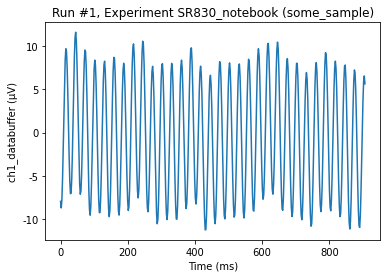

In [10]:
doNd.do0d(sr.ch1_databuffer, do_plot=True)

As mentioned earlier, the result is only the noise data stored in the channel 1 buffer. We may like to look at the snapshot again to see what has been changed:

In [11]:
sr.print_readable_snapshot()

lockin:
	parameter       value
--------------------------------------------------------------------------------
IDN              :	{'vendor': 'Stanford_Research_Systems', 'model': 'SR830', ...
P                :	None (deg)
R                :	8.5319e-06 (V)
R_offset         :	None 
X                :	None (V)
X_offset         :	None 
Y                :	None (V)
Y_offset         :	None 
amplitude        :	None (V)
aux_in1          :	None (V)
aux_in2          :	None (V)
aux_in3          :	None (V)
aux_in4          :	None (V)
aux_out1         :	None (V)
aux_out2         :	None (V)
aux_out3         :	None (V)
aux_out4         :	None (V)
buffer_SR        :	512 (Hz)
buffer_acq_mode  :	None 
buffer_npts      :	464 
buffer_trig_mode :	None 
ch1_databuffer   :	Not available (V)
ch1_display      :	X 
ch1_ratio        :	none 
ch2_databuffer   :	Not available (V)
ch2_display      :	None 
ch2_ratio        :	None 
ext_trigger      :	None 
filter_slope     :	None (dB/oct)
frequency        :	None (Hz)
